# code in progress. see demo.ipynb for working version 


TO DO:
- make sure derived variables does the rotation BEFORE computing vorticity
- for DERIVED=FALSE, rotate the vectors after subsampling (is this possible?)
- test long time series - what makes the code crash? how can we optimize the sampling?
- what are optimal chunk sizes?

- try loading files one by one, pre-processing (e.g., cut domain), and then using .concat (result: for 90 files, just loading ds is 26.1 s. with same chunking, was 8 sec for loading w concat!). BUT NOTE! there was a problem loading one of the derived files that may have been causing the crash. Easier to troubleshoot when loading individually, anyway.

- compare sim_mooring and mooring. Choose the fastest method.

- different T/S and U/V sampling ......

- make the plotting in a separate function that loads the output nc files


In [18]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os
from pathlib import Path 



# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid

import xgcm.grid

# Third-party packages for data visualizations

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.dates as mdates

# osse tools package
# del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

# # dask
# import dask
# from dask.distributed import Client


In [ ]:
# set up dask client
# client = Client()
# client

In [24]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
# NOTE: ndays must be >1 
ndays = 5


# directory where data files are stored
datadir = '/data3/llc4320/' + RegionName + '/'                      # input model data are here
outputdir = '/data3/adac/osse_output/' + RegionName + '/'           # interpolated data stored here
figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures


# kd: lab
datadir = '/Users/kdrushka/data/adac/mitgcm/netcdf/' + RegionName + '/'                      # input model data are here
outputdir = '/Users/kdrushka/data/adac/osse_output/' + RegionName + '/'           # interpolated data stored here
figdir = '/Users/kdrushka/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures



SAVE_FIGURES = True # True or False


# optional details for sampling (if not specified, reasonable defaults will be used)
# NOTE!! mooring and sim_mooring are different:
#    sim_mooring treats the mooring datapoints like a glider, 
#    whereas mooring interpolates directly to the mooring grid and should be faster
sampling_details = {
    'SAMPLING_STRATEGY' : 'sim_glider', 
   # 'SAMPLING_STRATEGY' : 'trajectory_file', # options: sim_glider, sim_uctd or trajectory_file.add:  ASV
#     'SAMPLING_STRATEGY' : 'mooring', # options: sim_glider, sim_uctd, sim_mooring or trajectory_file.add: ASV. 
#     'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
#     'zmooring_TS' : list(range(-10,-1000,-10)) # instrument depths for moorings. T/S and U/V are the same.
    'hspeed' : 0.25,  # platform horizontal speed in m/s (for glider, uCTD)
    'vspeed' : 0.1, # platform vertical (profile) speed in m/s  (for glider, uCTD)
   # 'trajectory_file' : '../data/survey_trajectory_ACC_SMST_glider.nc', # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    'AT_END' : 'reverse', # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
    'DERIVED_VARIABLES' : True, # specify whether or not to process the derived variables (steric height, rotated velocity, vorticity) - slower and takes significant to derive/save the stored variables
    'SAVE_PRELIMINARY' : False
}


#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. 

In [8]:
# uncomment the following two lines if troubleshooting osse_tools
# del sys.modules['osse_tools']  
# from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp


# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)


# derive & save new files with steric height & vorticity
if sampling_details['DERIVED_VARIABLES']:
    compute_derived_fields(RegionName, datadir, start_date, ndays)

Please provide your Earthdata Login credentials for access.
Your info will only be passed to urs.earthdata.nasa.gov and will not be exposed in Jupyter.


Username:  kdrushka
Password:  ········


computing derived fields for /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120101.nc



/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


interpolating to tracer grid
rotating to east/north
 ... saving to  /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/derived/LLC4320_pre-SWOT_ACC_SMST_derived-fields_20120101.nc
computing derived fields for /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120102.nc


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


interpolating to tracer grid
rotating to east/north
 ... saving to  /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/derived/LLC4320_pre-SWOT_ACC_SMST_derived-fields_20120102.nc
computing derived fields for /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120103.nc


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


interpolating to tracer grid
rotating to east/north
 ... saving to  /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/derived/LLC4320_pre-SWOT_ACC_SMST_derived-fields_20120103.nc
computing derived fields for /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120104.nc


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


interpolating to tracer grid
rotating to east/north
 ... saving to  /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/derived/LLC4320_pre-SWOT_ACC_SMST_derived-fields_20120104.nc
computing derived fields for /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/LLC4320_pre-SWOT_ACC_SMST_20120105.nc


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")


interpolating to tracer grid
rotating to east/north
 ... saving to  /Users/kdrushka/data/adac/mitgcm/netcdf/ACC_SMST/derived/LLC4320_pre-SWOT_ACC_SMST_derived-fields_20120105.nc


#### Load all model data files. 
If `DERIVED_VARIABLES = True`, do *not* load U, V, or oceTAUX, oceTAUY as we will replace these with transformed versions .

Note that if `DERIVED_VARIABLES = False`, the vector variables U,V, TAUX and TAUY are in the reference frame of the model and must be rotated.

In [9]:
%%time
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

# chunk size ... aiming for ~100 MB chunks
# these chunks seem to work OK for up to ~20 day simulations, but more 
# testing is needed to figure out optimal parameters for longer simulations
tchunk = 6 
xchunk = 150
ychunk = 150

# drop the vector variables if loading derived variables because we are going to load the rotated ones in the next cell
if sampling_details['DERIVED_VARIABLES']:
    drop_variables={'U', 'V', 'oceTAUX', 'oceTAUY'}
else:
    drop_variables={}

ds = xr.open_mfdataset(target_files, parallel=True, 
                       drop_variables=drop_variables,
                      chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)


CPU times: user 343 ms, sys: 944 ms, total: 1.29 s
Wall time: 1.26 s


In [10]:
%%time
# load the corresponding derived fields (includes steric height, vorticity, and transformed vector variables for current and wind stress)
if sampling_details['DERIVED_VARIABLES']:
    derivedir = datadir + 'derived/'
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    dsd = xr.open_mfdataset(derived_files, parallel=True, chunks={'i':xchunk, 'j':ychunk, 'time':tchunk})
    
    # merge the derived and raw data
    ds = ds.merge(dsd)
    # rename the transformed vector variables to their original names
    ds = ds.rename_vars({'U_transformed':'U', 'V_transformed':'V', 
                         'oceTAUX_transformed':'oceTAUX', 'oceTAUY_transformed':'oceTAUY'})


# drop a bunch of other vars we don't actually use - can comment this out if these are wanted
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

CPU times: user 185 ms, sys: 163 ms, total: 348 ms
Wall time: 336 ms


<xarray.Dataset>
Dimensions:             (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84, k_l: 84, k_p1: 85, time: 120, zref: 27)
Coordinates:
  * j_g                 (j_g) float32 0.0 1.0 2.0 3.0 ... 346.0 347.0 348.0
  * i                   (i) float32 0.0 1.0 2.0 3.0 ... 188.0 189.0 190.0 191.0
  * i_g                 (i_g) float32 0.0 1.0 2.0 3.0 ... 189.0 190.0 191.0
  * j                   (j) float32 0.0 1.0 2.0 3.0 ... 345.0 346.0 347.0 348.0
  * k                   (k) int32 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83
  * k_u                 (k_u) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_l                 (k_l) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_p1                (k_p1) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * time                (time) datetime64[ns] 2012-01-01 ... 2012-01-05T23:00:00
  * zref                (zref) float64 0.0 5.0 10.0 ... 1.5e+03 1.75e+03 2e+03
    yav                 float64 -55.5
    xav                 float64 152.5
Data variables: (12/28)
    XC                  (time, j, i) float32 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    YC                  (time, j, i) float32 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    Depth               (time, j, i) float32 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    AngleSN             (time, j, i) float32 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    AngleCS             (time, j, i) float32 dask.array<chunksize=(24, 150, 150), meta=np.ndarray>
    XG                  (time, j_g, i_g) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    ...                  ...
    U                   (j, i, time, k) float32 dask.array<chunksize=(150, 150, 6, 84), meta=np.ndarray>
    V                   (j, i, time, k) float32 dask.array<chunksize=(150, 150, 6, 84), meta=np.ndarray>
    oceTAUX             (j, i, time) float32 dask.array<chunksize=(150, 150, 6), meta=np.ndarray>
    oceTAUY             (j, i, time) float32 dask.array<chunksize=(150, 150, 6), meta=np.ndarray>
    Tref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
    Sref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

### Create & plot sampling track
Based on the parameters in `sampling_details`

In [12]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)

# print specified sampling_details + any default values
sampling_parameters

originally,  42840  points
limited to  41958 points: n_profiles= 21.0 ,  999 depths per profile,  1998 depths per two-way


{'zrange': [-1, -1000.0],
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAMPLING_STRATEGY': 'sim_glider',
 'DERIVED_VARIABLES': True,
 'distance_total_km': 104.8925,
 'time_total_s': 419570.0}

In [31]:
# ---- generate name of file to save outputs in ---- 
filename_base = (f'OSSE_{RegionName}_{sampling_parameters["SAMPLING_STRATEGY"]}_{start_date}_to_{start_date + datetime.timedelta(ndays)}_maxdepth{int(sampling_parameters["zrange"][1])}')
filename_out_base = (f'{outputdir}{filename_base}')
Path(outputdir).mkdir(parents=True, exist_ok=True) # create outputdir if it doesn't exist
 
print(filename_base)


/Users/kdrushka/data/adac/osse_output/ACC_SMST/


### Visualize the track over a single model snapshot:

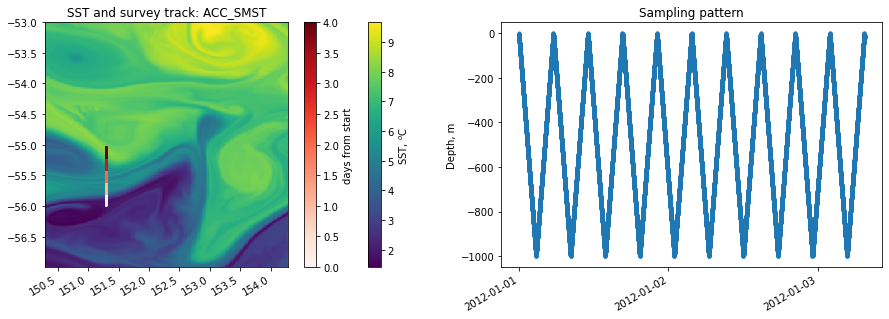

In [20]:
%matplotlib inline
plt.figure(figsize=(15,5))

# map of Theta at time zero
ax = plt.subplot(1,2,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_parameters['SAMPLING_STRATEGY'] == 'mooring' or sampling_parameters['SAMPLING_STRATEGY'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName)
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region')


# depth/time plot of first few datapoints
ax = plt.subplot(1,2,2)
iplot = slice(0,20000)
if not (sampling_parameters['SAMPLING_STRATEGY'] == 'mooring' or sampling_parameters['SAMPLING_STRATEGY'] == 'sim_mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.dep.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['dep'].data.size))),
         np.tile(survey_track['dep'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Depth, m')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Sampling pattern')


# save
if SAVE_FIGURES:
    Path(figdir).mkdir(parents=True, exist_ok=True) # create figdir if it doesn't exist
    plt.savefig(figdir + filename_base + '_sampling.png', dpi=400, transparent=False, facecolor='white')

plt.show()


### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [25]:
%%time

del sys.modules['osse_tools'] 
from osse_tools import survey_interp, get_survey_track
subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_details)
sgridded

Interpolating model fields to the sampling track...


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

Gridding the interpolated data...
Theta


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

Salt


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

vorticity


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

steric_height


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

U


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

V


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

CPU times: user 17.3 s, sys: 5.01 s, total: 22.3 s
Wall time: 22.5 s


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

<xarray.Dataset>
Dimensions:             (depth: 999, time: 42)
Coordinates:
  * depth               (depth) float64 -1.0 -2.0 -3.0 ... -997.0 -998.0 -999.0
  * time                (time) datetime64[ns] 2012-01-01 ... 2012-01-05T17:46:20
Data variables: (12/16)
    Theta               (depth, time) float64 1.858 1.94 1.94 ... 2.196 2.196
    Salt                (depth, time) float64 33.81 33.81 33.81 ... 34.64 34.64
    vorticity           (depth, time) float64 -2.273e-05 ... -5.355e-05
    steric_height       (time) float64 0.6043 0.6043 0.6301 ... 0.7538 0.7538
    U                   (depth, time) float64 0.3787 0.7876 ... 0.2273 0.2274
    V                   (depth, time) float64 0.2305 0.02841 ... 0.2608 0.2608
    ...                  ...
    oceTAUX             (time) float64 0.1813 0.1178 0.08026 ... 0.2678 0.321
    oceTAUY             (time) float64 0.111 0.04031 ... -0.05219 -0.07464
    oceFWflx            (time) float64 4.698e-06 9.589e-06 ... -2.615e-05
    oceQnet             (time) float64 -396.8 -585.0 -389.0 ... 202.0 46.24
    oceQsw              (time) float64 -471.7 -662.9 -453.9 ... -0.7889 -103.6
    oceSflux            (time) float64 nan nan nan nan nan ... nan nan nan nan

### Visualizations

Basic plots to show the interpolated variables

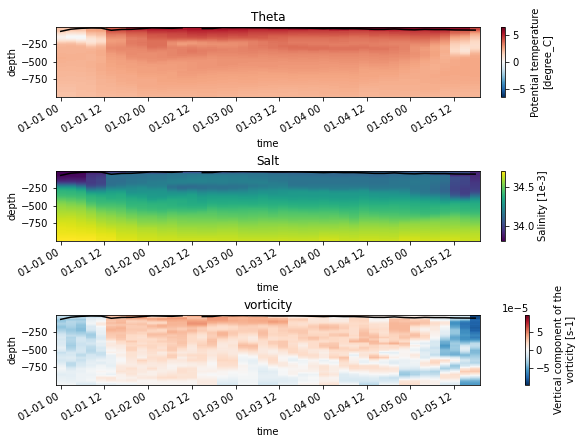

In [27]:
# 3d fields
vbls3d = ['Theta','Salt','U','V','vorticity']
vbls3d = ['Theta','Salt','vorticity']
ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


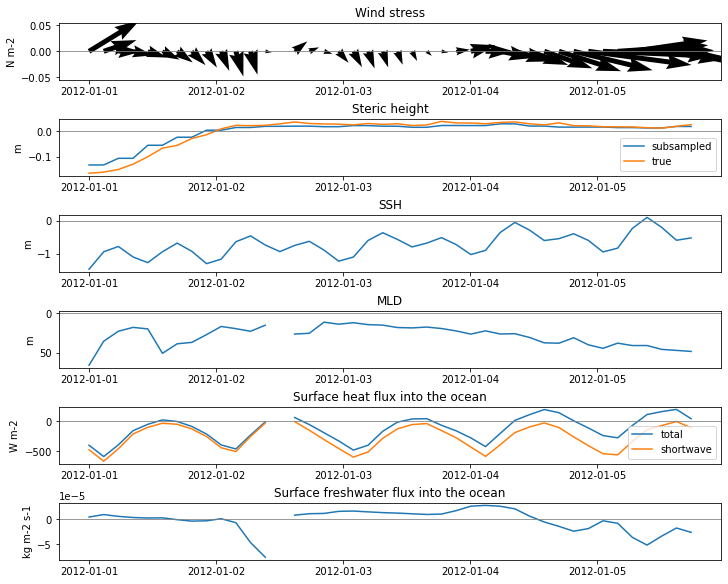

In [28]:
## selected 2d fields
j=0
nr = 6 # # of rows
fig,ax=plt.subplots(nr,figsize=(10,8),constrained_layout=True)


# wind vectors
ax[j].quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)
ax[j].set_title('Wind stress')    
ax[j].set_ylabel('N m-2')
# SH 
j+=1
ax[j].plot(sgridded.time,sgridded.steric_height-sgridded.steric_height.mean(), 
             sgridded.time.data,sgridded.steric_height_true-sgridded.steric_height_true.mean())
ax[j].set_title('Steric height')
ax[j].legend(['subsampled','true'])
ax[j].set_ylabel('m')

# SSH
j+=1
ax[j].plot(sgridded.time,sgridded.Eta)
ax[j].set_title('SSH')
ax[j].set_ylabel('m')

# MLD
j+=1
ax[j].plot(sgridded.time,sgridded.KPPhbl)
ax[j].set_title('MLD')
ax[j].set_ylabel('m')
ax[j].invert_yaxis()

# surface heat flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceQnet, sgridded.time,sgridded.oceQsw)
ax[j].set_title('Surface heat flux into the ocean')
ax[j].legend(['total','shortwave'])
ax[j].set_ylabel('W m-2')

# surface FW flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceFWflx)
ax[j].set_title('Surface freshwater flux into the ocean') 
ax[j].set_ylabel('kg m-2 s-1')

# horiz line:
for j in range(nr):
    ax[j].axhline(0, color='grey', linewidth=0.8)

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_2D.png', dpi=400, transparent=False, facecolor='white')
   

### Save interpolated data

For both raw and gridded subsampled data, add attributes and save


In [29]:
# add metadata to attributes
attrs = sampling_parameters
attrs['start_date'] = start_date.strftime('%Y-%m-%d')
end_date = sgridded['time'].data[-1]
attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
attrs['ndays'] = ndays
attrs.pop('DERIVED_VARIABLES')

True

In [40]:
# ------ subsampled data
# this is slow and generates a huge file, so consider skipping
if sampling_parameters['SAMPLING_STRATEGY'] != 'mooring':
    filename_out = filename_out_base + '_subsampled.nc'
    print(f'saving to {filename_out}')
    subsampled_data.attrs = attrs
    netcdf_fill_value = nc4.default_fillvals['f4']
    dv_encoding={'zlib':True,  # turns compression on\
                'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                'dtype':'float32',\
                '_FillValue':netcdf_fill_value}
    # save to a new file
    # subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
    subsampled_data.to_netcdf(filename_out,format='netcdf4')
    !ls -ltrh {filename_out}

saving to /Users/kdrushka/data/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_glider_2012-01-01_to_2012-01-06_maxdepth-1000_subsampled.nc


/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/Users/kdrushka/opt/miniconda3/envs/py33/lib/python3.9/site-packages/xarray/core/missing.py:563: 

-rw-r--r--  1 kdrushka  staff   6.6M Jun 23 14:12 /Users/kdrushka/data/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_glider_2012-01-01_to_2012-01-06_maxdepth-1000_subsampled.nc


In [41]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}

saving to /Users/kdrushka/data/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_glider_2012-01-01_to_2012-01-06_maxdepth-1000_gridded.nc
-rw-r--r--  1 kdrushka  staff   1.7M Jun 23 14:12 /Users/kdrushka/data/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_glider_2012-01-01_to_2012-01-06_maxdepth-1000_gridded.nc


In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}


### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(subsampled_data.lon.data, subsampled_data.lat.data, subsampled_data.dep.data, c=subsampled_data.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')